<b>Group Number: 5</b> 
<br><b>Name Group Member 1: Anton Sewergin</b> 
<br><b>u-Kürzel Group Member 1: uhsno</b> 
<br><b>Name Group Member 2: Jan Schmidgen</b> 
<br><b>u-Kürzel Group Member 2: utwub</b> 

# 3 PCA and Clustering with Samsung Human Activity Recognition Dataset

In this part of the task, we will work with the [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. The dataset resides in the folder "data". The data comes from accelerometers and gyros of Samsung Galaxy S3 mobile phones (you can find more info about the features using the link above). The type of activity of a person with a phone in his/her pocket is also known – whether he/she walked, stood, lay, sat or walked up or down the stairs.

First, we pretend that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. Then, we solve the problem of determining the type of physical activity as a classification problem.

## 3.1 Preparation

We import the necessary libraries Pandas, Seaborn, Numpy. From scikit-learn, import the metrics, KMeans, PCA, GridSearchCV, StandardScaler and some other necessary imports and definitions.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import os
from typing import *
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
%matplotlib inline
plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from lama.checkpoints import lama_compare_checkpoint

#Define a fixed random state
RANDOM_STATE = 17

### 3.1.1 Import your dataset

Let's proceed with importing our dataset.

<div class="alert alert-block alert-success">
<b>Task:</b>  Load both the training and test data as well as the corresponding labels. Tip: Numpy has a function to load text files. Load the labels as integer type.

</div>

In [2]:
X_train: np.ndarray
y_train: np.ndarray
X_test: np.ndarray
y_test: np.ndarray

### STUDENT CODE HERE (2 pts)

X_train = np.loadtxt("data/X_train.txt")
y_train = np.loadtxt("data/y_train.txt", dtype=int)
X_test = np.loadtxt("data/X_test.txt")
y_test = np.loadtxt("data/y_test.txt", dtype=int)

### STUDENT CODE until HERE

# Check if the dimensions of the dataset are correct.
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

### 3.1.2 Data Understanding

Now after we loaded the data, we want to get a quick understanding of our dataset. 


<div class="alert alert-block alert-success">
<b>Task:</b> Use the code block below to display the following information:
<ul>
    <li> How many observations and features do we have?</li>
    <li> How many of the features are numeric?</li>
    <li> Do we have missing values?</li>
</ul>
</div>

In [3]:
### STUDENT CODE HERE (1 pt)

# print shape of the numpy array
observation_count, feature_count = X_train.shape
print(f"Observations: {observation_count}\nFeatures: {feature_count}")

# find datatypes in array
foundDataTypes = []
for feature in X_train[0]:
    if type(feature) not in foundDataTypes:
        foundDataTypes.append(type(feature))
print(f"Found Datatypes: {foundDataTypes}")
print(f"All of the Observations are numeric, since loadtxt will load all the data as float and no exeption was thrown.")

# check for missing data
missing_data_counter = 0
for observation in np.isnan(X_train):
    for datapoint in observation:
        if datapoint == True:
            missing_data_counter += 1
print(f"Missing data count: {missing_data_counter}")

### STUDENT CODE until HERE

Observations: 7352
Features: 561
Found Datatypes: [<class 'numpy.float64'>]
All of the Observations are numeric, since loadtxt will load all the data as float and no exeption was thrown.
Missing data count: 0


Now we load the feature names of the file "features.txt". For clustering, we do not need a target vector, so in the beginning we'll work with the combination of training and test samples. The following code merges `X_train` with `X_test`, and `y_train` with `y_test`. Afterwards the merged data `X_train` with `X_test` is put in one dataframe with the specified feature names. 

In [4]:
featureNames = np.loadtxt('data/features.txt', dtype=str)
X = pd.DataFrame(data=np.vstack((X_train,X_test)), columns=featureNames)
y = pd.Series(data=np.concatenate((y_train,y_test)), name='label')

# Checking dimensions
assert(X.shape == (7352+2947, 561))
assert(y.shape == (7352+2947,))

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Use the <code>.describe()</code> method from pandas to get a summary of the numeric values. What can we see from that summary? Especially, have a look on scaling or centering.
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> I assume that the dataset was normalized using min max scaling into the ranges between -1 and 1, because alle features are between these values. I don't think it was standardized, since standard deviation is never one while the mean is not always at 0.
</div>

In [5]:
### STUDENT CODE HERE (1 pt)

print(f"Maximum standard deviation: {X.std().abs().max()}")
print(f"Biggest mean: {X.mean().abs().max()}")

X.describe()

### STUDENT CODE until HERE

Maximum standard deviation: 0.7494800519998022
Biggest mean: 0.9845489472644913


(1, tBodyAcc-mean()-X)  (2, tBodyAcc-mean()-Y)  (3, tBodyAcc-mean()-Z)  \
count            10299.000000            10299.000000            10299.000000   
mean                 0.274347               -0.017743               -0.108925   
std                  0.067628                0.037128                0.053033   
min                 -1.000000               -1.000000               -1.000000   
25%                  0.262625               -0.024902               -0.121019   
50%                  0.277174               -0.017162               -0.108596   
75%                  0.288354               -0.010625               -0.097589   
max                  1.000000                1.000000                1.000000   

       (4, tBodyAcc-std()-X)  (5, tBodyAcc-std()-Y)  (6, tBodyAcc-std()-Z)  \
count           10299.000000           10299.000000           10299.000000   
mean               -0.607784              -0.510191              -0.613064   
std                 0.438694               0.500240               0.403657   
min                -1.000000              -1.000000              -1.000000   
25%                -0.992360              -0.976990              -0.979137   
50%                -0.943030              -0.835032              -0.850773   
75%                -0.250293              -0.057336              -0.278737   
max                 1.000000               1.000000               1.000000   

       (7, tBodyAcc-mad()-X)  (8, tBodyAcc-mad()-Y)  (9, tBodyAcc-mad()-Z)  \
count           10299.000000           10299.000000           10299.000000   
mean               -0.633593              -0.525697              -0.614989   
std                 0.413333               0.484201               0.399034   
min                -1.000000              -1.000000              -1.000000   
25%                -0.993293              -0.977017              -0.979064   
50%                -0.948244              -0.843670              -0.845068   
75%                -0.302033              -0.087405              -0.288149   
max                 1.000000               1.000000               1.000000   

       (10, tBodyAcc-max()-X)  ...  (552, fBodyBodyGyroJerkMag-meanFreq())  \
count            10299.000000  ...                            10299.000000   
mean                -0.466732  ...                                0.126708   
std                  0.538707  ...                                0.245443   
min                 -1.000000  ...                               -1.000000   
25%                 -0.935788  ...                               -0.019481   
50%                 -0.874825  ...                                0.136245   
75%                 -0.014641  ...                                0.288960   
max                  1.000000  ...                                1.000000   

       (553, fBodyBodyGyroJerkMag-skewness())  \
count                            10299.000000   
mean                                -0.298592   
std                                  0.320199   
min                                 -1.000000   
25%                                 -0.536174   
50%                                 -0.335160   
75%                                 -0.113167   
max                                  1.000000   

       (554, fBodyBodyGyroJerkMag-kurtosis())  \
count                            10299.000000   
mean                                -0.617700   
std                                  0.308796   
min                                 -1.000000   
25%                                 -0.841847   
50%                                 -0.703402   
75%                                 -0.487981   
max                                  1.000000   

       (555, angle(tBodyAccMean,gravity))  \
count                        10299.000000   
mean                             0.007705   
std                              0.336591   
min                             -1.000000   
25%                             -0.124694   
50%           

## 3.2 Data Visualization and Reduction with PCA

As we have seen, the dataset contains more than 500 columns (features). It is not possible to show all of the data. We won't be able to see or recognize anything, if we try to plot a distribution or histograms of all features. Besides that, we also don't know which columns may be interesting. But, what luck we learned a method to visualize datasets with such a high dimension: PCA!

<div class="alert alert-block alert-success">
<b>Task:</b> Perform the necessary scaling to fulfill the requirements of PCA.
</div>

In [6]:
X_scaled: np.ndarray

### STUDENT CODE HERE (2 pts)

# it is necessary to mean center the data for PCA
X_scaled = X - X.mean()
X_scaled.describe()

### STUDENT CODE until HERE

(1, tBodyAcc-mean()-X)  (2, tBodyAcc-mean()-Y)  (3, tBodyAcc-mean()-Z)  \
count            1.029900e+04            1.029900e+04            1.029900e+04   
mean             3.725106e-16           -5.202655e-17           -2.805256e-16   
std              6.762780e-02            3.712817e-02            5.303309e-02   
min             -1.274347e+00           -9.822565e-01           -8.910750e-01   
25%             -1.172247e-02           -7.158987e-03           -1.209385e-02   
50%              2.826619e-03            5.818678e-04            3.286127e-04   
75%              1.400696e-02            7.118932e-03            1.133569e-02   
max              7.256527e-01            1.017743e+00            1.108925e+00   

       (4, tBodyAcc-std()-X)  (5, tBodyAcc-std()-Y)  (6, tBodyAcc-std()-Z)  \
count           1.029900e+04           1.029900e+04           1.029900e+04   
mean           -9.631204e-16           2.099064e-16          -1.350852e-15   
std             4.386938e-01           5.002398e-01           4.036566e-01   
min            -3.922162e-01          -4.898086e-01          -3.869357e-01   
25%            -3.845767e-01          -4.667989e-01          -3.660726e-01   
50%            -3.352462e-01          -3.248406e-01          -2.377087e-01   
75%             3.574910e-01           4.528558e-01           3.343269e-01   
max             1.607784e+00           1.510191e+00           1.613064e+00   

       (7, tBodyAcc-mad()-X)  (8, tBodyAcc-mad()-Y)  (9, tBodyAcc-mad()-Z)  \
count           1.029900e+04           1.029900e+04           1.029900e+04   
mean           -8.003006e-17           9.579460e-16           1.777219e-15   
std             4.133330e-01           4.842006e-01           3.990341e-01   
min            -3.664074e-01          -4.743035e-01          -3.850111e-01   
25%            -3.597006e-01          -4.513201e-01          -3.640749e-01   
50%            -3.146512e-01          -3.179737e-01          -2.300794e-01   
75%             3.315601e-01           4.382920e-01           3.268399e-01   
max             1.633593e+00           1.525697e+00           1.614989e+00   

       (10, tBodyAcc-max()-X)  ...  (552, fBodyBodyGyroJerkMag-meanFreq())  \
count            1.029900e+04  ...                            1.029900e+04   
mean             1.964186e-15  ...                           -2.204276e-16   
std              5.387068e-01  ...                            2.454430e-01   
min             -5.332676e-01  ...                           -1.126708e+00   
25%             -4.690561e-01  ...                           -1.461886e-01   
50%             -4.080922e-01  ...                            9.537280e-03   
75%              4.520917e-01  ...                            1.622521e-01   
max              1.466732e+00  ...                            8.732922e-01   

       (553, fBodyBodyGyroJerkMag-skewness())  \
count                            1.029900e+04   
mean                             1.083165e-16   
std                              3.201987e-01   
min                             -7.014081e-01   
25%                             -2.375825e-01   
50%                             -3.656785e-02   
75%                              1.854244e-01   
max                              1.298592e+00   

       (554, fBodyBodyGyroJerkMag-kurtosis())  \
count                            1.029900e+04   
mean                            -1.980744e-15   
std                              3.087955e-01   
min                             -3.822999e-01   
25%                             -2.241474e-01   
50%                             -8.570205e-02   
75%                              1.297191e-01   
max                              1.617700e+00   

       (555, angle(tBodyAccMean,gravity))  \
count                        1.029900e+04   
mean                        -5.174357e-18   
std                          3.365910e-01   
min                         -1.007705e+00   
25%                         -1.323990e-01   
50%           

<div class="alert alert-block alert-success">
<b>Task:</b> 
<ul>
    <li> Now copy the function to plot the accumulated variance of the principal components you edited in the beginning of the task. Modify the plotting function such that only 100 features are displayed.</li>
    <li> When you are happy with your function, use the sklearn-PCA to calculate the transformation with all the features of X_scaled. (At first we don't specify a number of components we want to retain or a ratio of explained variance) </li>
    <li> Then plot the variance by calling your function.</li>
</ul>
    

</div>

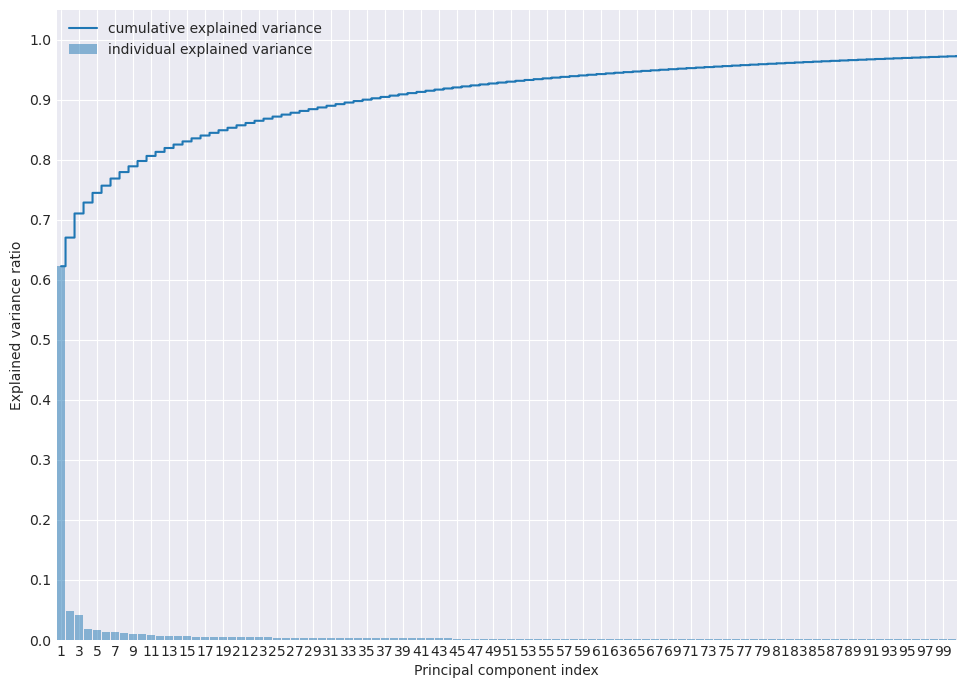

In [7]:
from sklearn import decomposition

def plotPCAVariance(var_exp: np.ndarray, X: np.ndarray) -> Tuple[plt.Figure, plt.Axes]:
    
    ### STUDENT CODE HERE (3 pts)

    cum_var_exp = np.cumsum(var_exp)
    
    #plotting individual explained variance is given
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
    ax.bar(range(1, X.shape[1]+1), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
    ax.set_ylabel('Explained variance ratio')
    ax.set_xlabel('Principal component index')    
    ax.set_xlim(0.5, 100+0.5)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(np.arange(1,100+1,2))

    # plotting
    ax.step(range(1, X.shape[1]+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
    ax.legend(loc='best')
    
    ### STUDENT CODE until HERE

    return fig, ax


# PCA transformation and plot by calling your function

### STUDENT CODE HERE (1 pt)

# fit to centered data with k=Number of Features
pca = decomposition.PCA().fit(X_scaled)
# We have to get the explained variances for all PCs so we don't specify k when we call the PCA().fit() function.
var_exp = pca.explained_variance_ratio_
# Afterwards we can use the result as input for our function and plot the explained variances.
fig, ax = plotPCAVariance(var_exp, X_scaled)

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Task:</b>  Now, reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the data. Use the scaled dataset and set a fixed <code>random_state</code> (use the RANDOM_STATE constant).


</div>

In [8]:
X_pca: np.ndarray

### STUDENT CODE HERE (1 pt)
# get appropriate number of principal components
pc_count = 0;
for index, cumulative_sum in enumerate(np.cumsum(var_exp)):
    if cumulative_sum > 0.9:
        pc_count = index + 1
        break
print(f"Minimum PC count for >90% cumulative variance: {pc_count}")

# reduce dimensions of data
PCA_90 = decomposition.PCA(n_components=pc_count, random_state=RANDOM_STATE)
X_reduced = PCA_90.fit_transform(X_scaled)
print(f"Shape of X_reduced: {X_reduced.shape}")

### STUDENT CODE until HERE

Minimum PC count for >90% cumulative variance: 36
Shape of X_reduced: (10299, 36)


<div class="alert alert-block alert-success">
<b>Task:</b> Use the code block below to find out:
<ul>
    <li> the minimum number of principal components required to cover the 90% of the variance of the data.</li>
    <li> the ratio of the variance covered by the first principal component. Round to two decimal places.</li>
</div>

In [9]:
### STUDENT CODE HERE (1 pt)

print(f"Minimum number of principal components required to cover the 90% of the variance of the data: {pc_count}")
print(f"Ratio of the variance covered by the first principal component: {PCA_90.explained_variance_ratio_[0]}")

### STUDENT CODE until HERE

Minimum number of principal components required to cover the 90% of the variance of the data: 36
Ratio of the variance covered by the first principal component: 0.6222706941592145


<div class="alert alert-block alert-success">
<b>Task:</b> Visualize the data in projection on the first two principal components.


</div>

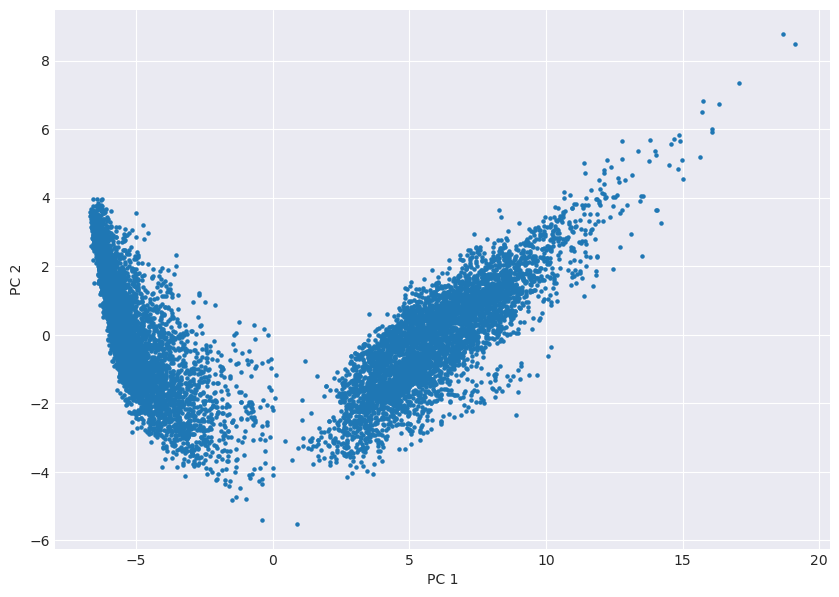

In [10]:
### STUDENT CODE HERE (1 pt)

PCA_2d = decomposition.PCA(n_components=2, random_state=RANDOM_STATE)
X_2d_reduced = PCA_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
plt.scatter(X_2d_reduced[:, 0], X_2d_reduced[:, 1], s=5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Describe the plot results. What can we conclude looking at the results? What is the benefit of PCA?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> We can see two distinct clusters, that we could label. PCA makes it possible to visualize our data at all, since we can only display 2d or 3d datapoints. Though we must be careful, since the 2d PC decomposition can only give a rough estimate since the variance is not very high.
</div>

## 3.3 Clustering

<div class="alert alert-block alert-success">
<b>Task:</b> Perform clustering with <code>KMeans</code>, training the model on data with reduced dimensionality (by PCA).

</div>

As a first try, we will look for the number of clusters we see with naked eye. In general case we will not know how many clusters we should be looking for.

Parameters of the K-Means Algorithm:

- ** n_clusters ** = as noted above
- ** n_init ** = 100
- ** random_state ** = RANDOM_STATE (for reproducibility of the result)

Other parameters should have default values.

In [11]:
### STUDENT CODE HERE (1 pt)

kmeans = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_reduced)
labels_kmeans = kmeans.labels_

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Task:</b> Visualize your results using the predicted cluster labels as the color of your plot.

</div>

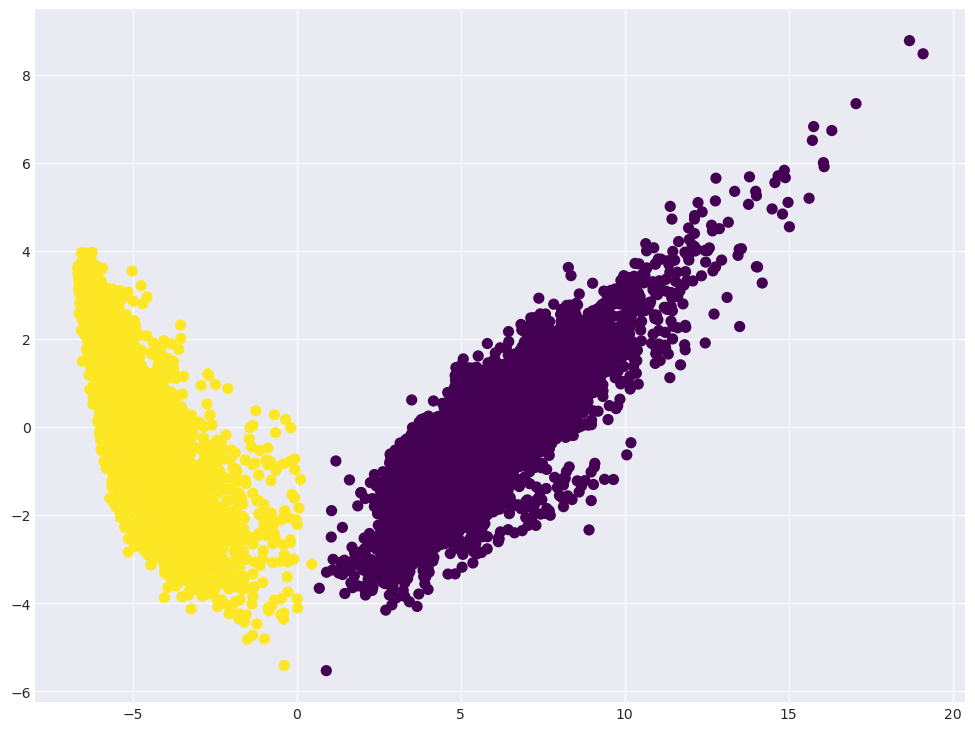

In [12]:
### STUDENT CODE HERE (1 pt)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_kmeans, s=50, cmap='viridis');

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> What is your interpretation of the clustering result? Describe the plot.
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> The clustering result is similar to how most people would intuitivly cluster the data. The plots groups the left data points together, while grouping right data points together.
</div>

### 3.3.1 Varying the number of clusters

Our first estimate of the number of clusters led to a nice result. But what if we could get more information out of the dataset if we vary the number of clusters?

#### 3.3.1.1 Elbow Method

<div class="alert alert-block alert-success">
<b>Task:</b> <ul>
    <li> We want to use the elbow method we learned before to estimate the number of clusters. Therefore, complete the method.</li>
    <li> Use the code below to call your function and plot the loss versus the k-values. Use a range of one to ten for the value of k.</li>
</ul>

</div>

C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The defa

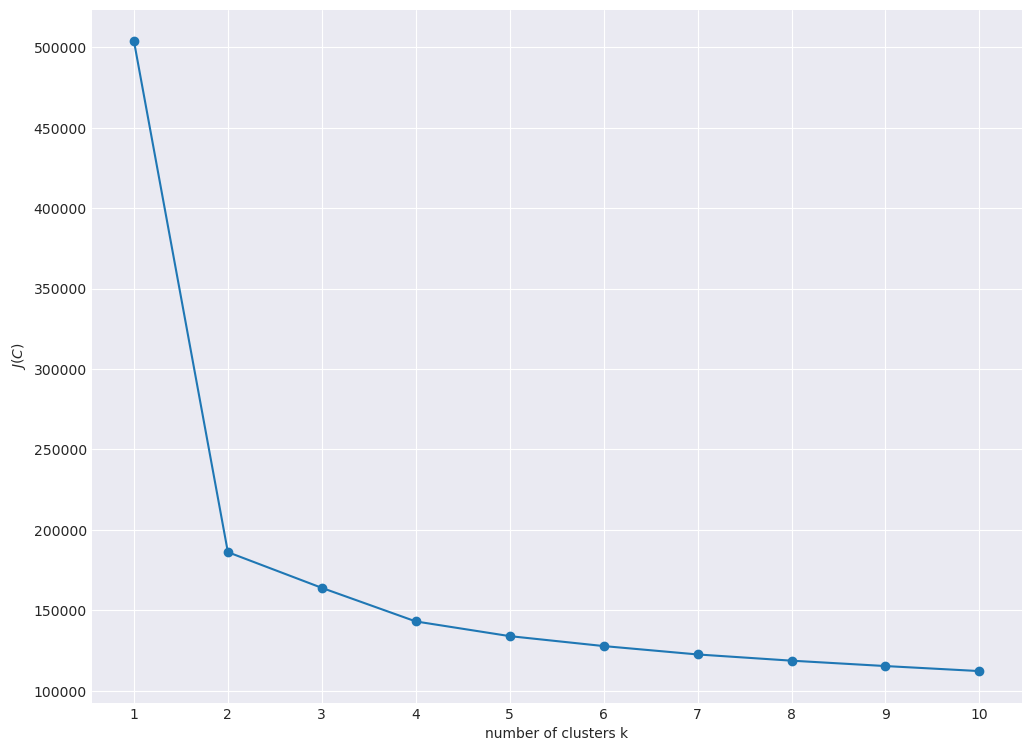

In [13]:
from sklearn.metrics import pairwise_distances_argmin_min

def calculate_k_loss(X: np.ndarray, k_min: int, k_max: int) -> Tuple[List[int], List[float]]:
    k_values: List[int]
    losses: List[float]

    ### STUDENT CODE HERE (3 pts)

    losses = []
    k_values = range(k_min, k_max + 1)
    
    for n in k_values:
        kmeans = KMeans(n_clusters=n, random_state=RANDOM_STATE)
        kmeans.fit(X)
        losses.append(kmeans.inertia_)

    ### STUDENT CODE until HERE
    
    return k_values, losses


# call your function
### STUDENT CODE HERE (1 pt)

k_values, losses = calculate_k_loss(X_reduced, 1, 10)

### STUDENT CODE until HERE


# compare your result with the checkpoint
# lama_compare_checkpoint([round(elem, 4) for elem in losses], 't4/checkpoint3_1.pkl')
#commented out because it requires too precise values, our values are almost the same

# Plot k_values vs inertias
plt.plot(k_values, losses, '-o')
plt.xlabel('number of clusters k')
plt.ylabel('$ J(C)$')
plt.xticks(k_values)
plt.show()


<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> How many clusters can we choose according to the elbow method?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> The elbow method suggests 2 as value for k.
</div>

#### 3.3.1.2 Silhouette Score

Let's use the silhouette score to get a value for $k$.

<div class="alert alert-block alert-success">
<b>Task:</b> Fill in the code below with the function we used in Task 2 already. Get the score for values of $k$ between $2$ and $10$.

</div>

2


C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3


C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


4


C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


5


C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


6


C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


7


C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8


C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


9


C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


10


C:\Users\Anton\anaconda3\envs\lama_2023_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


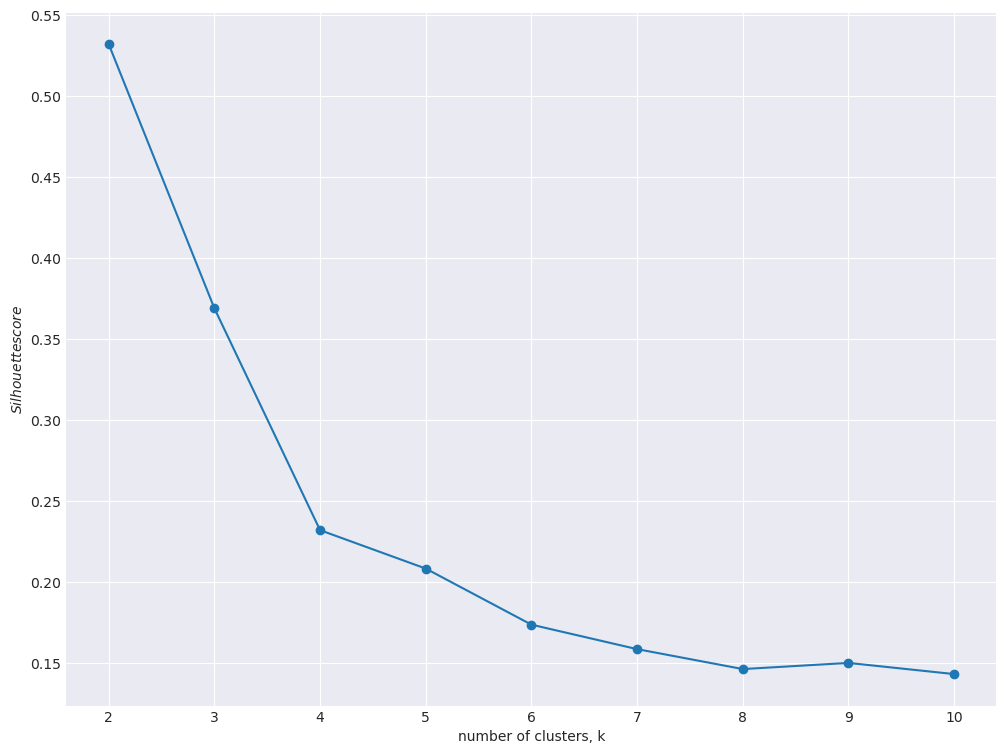

In [14]:
from sklearn.metrics import silhouette_score

def calculate_k_silhouette(X: np.ndarray, k_min: int, k_max: int) -> Tuple[List[int], List[float]]:
    ks: List[int]
    silhouettes: List[float]

    ### STUDENT CODE HERE (3 pts)

    silhouettes = []
    ks = range(k_min, k_max + 1)
    
    for n in ks:
        print(n)
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X)

        silhouettes.append(silhouette_score(X, kmeans.labels_))

    ### STUDENT CODE until HERE
    return ks, silhouettes


# call your function
### STUDENT CODE HERE (1 pt)

ks, silhouettes = calculate_k_silhouette(X_reduced, 2, 10)

### STUDENT CODE until HERE

# Plot ks vs inertias
plt.plot(ks, silhouettes, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('$ Silhouette score $')
plt.xticks(ks)
plt.show()


<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> What is your conclusion looking at the results of the two metrics? What value would you choose for $k$?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> The silhouette score declines rapidly for values after 2, so it suggests 2 as a value for k.
</div>

### 3.3.2 Analyzing the given Label Information

#### 3.3.2.1 Class Distribution

<div class="alert alert-block alert-success">
<b>Task:</b> Let's find out how many classes there are actually given in the dataset. Calculate the number of unique values of the labels of the target class. How many data points do we have in each class? Plot a histogram for the distribution of class labels.
</div>

In [15]:
n_classes: int

### STUDENT CODE HERE (2 pts)

value_counts = y.value_counts()
print(f"Values and counts: {value_counts}")
print(f"Number of unique values: {len(value_counts)}")

n_classes = len(value_counts)

### STUDENT CODE until HERE

Values and counts: label
6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64
Number of unique values: 6


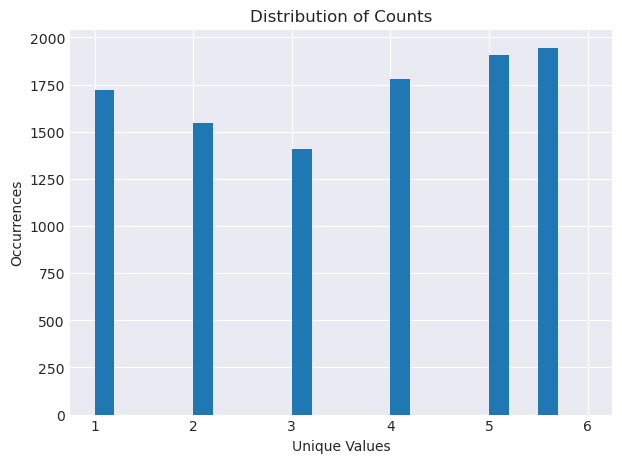

In [16]:
#plotting the histogram
### STUDENT CODE HERE (2 pts)

plt.xlabel('Unique Values')
plt.ylabel('Occurrences')
plt.title('Distribution of Counts')
y.hist(figsize=(7,5), width=0.2)
plt.show()

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b> [Have a look at the dataset description.](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names) 

What do the class labels represent?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> 
    We can only assume that the numbers correspond to mentioned order.
<ul>
    <li> 1 – WALKING</li> 
    <li> 2 – WALKING_UPSTAIRS</li> 
    <li> 3 – WALKING_DOWNSTAIRS</li> 
    <li> 4 – SITTING</li> 
    <li> 5 – STANDING</li> 
    <li> 6 – LAYING</li> 
</ul>
</div>

#### 3.3.2.2 Showing class distribution with PCA data

To get a better impression of the real classes in the dataset, we want to show the labels of the data points in our PCA transformed dataset.

<div class="alert alert-block alert-success">
<b>Task:</b> Make a scatter plot of the PCA transformed data and mark the classes in different colors.
</div>

C:\Users\Anton\AppData\Local\Temp\ipykernel_11028\1245383699.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(labels)


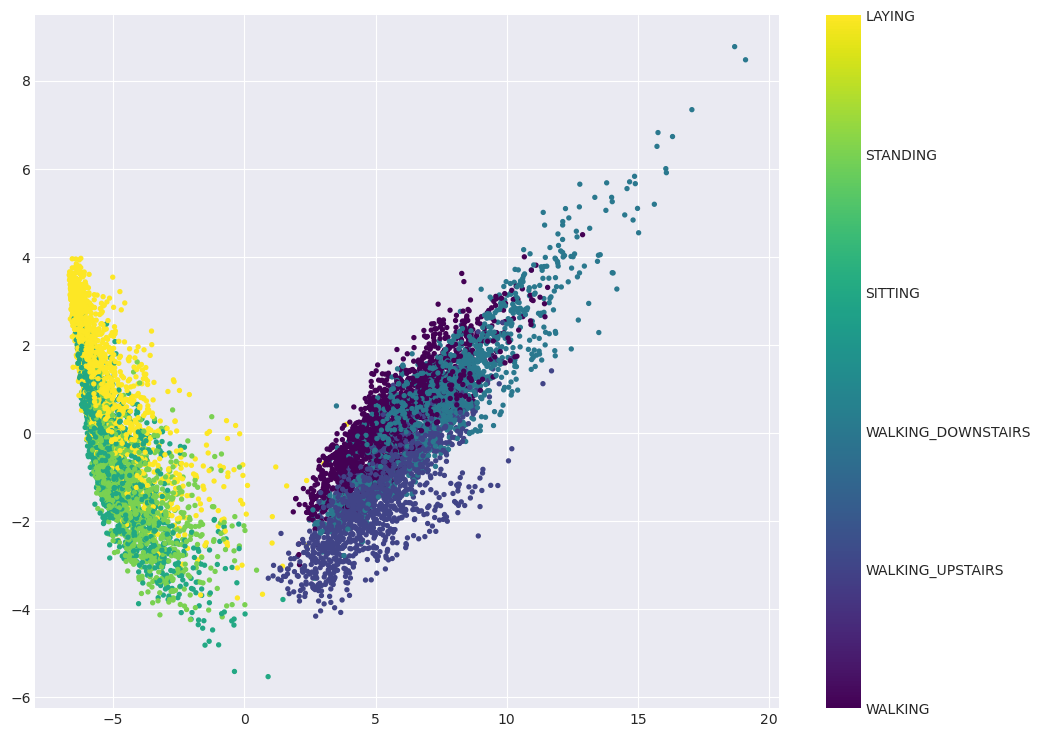

In [17]:
### STUDENT CODE HERE (2 pts)

labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=8, cmap='viridis', label=labels);
plt.colorbar().set_ticklabels(labels)
plt.show()

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b>  If everything worked out correctly, you see the same plot as before in subtask 2, but with label information to every datapoint. What problem do we have looking at the different classes we have in our dataset? What types of activity are included in which visually separated cluster?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> The problem is that certain activities' produced data overlaps a lot with other similar activities. We can see these overlaps with sedentary activities sitting, standing and laying in one cluster and the dynamic activities walking, walking upstairs and walking downstairs in the other cluster.
</div>

#### 3.3.2.3 Clustering of PCA data

Let's see if the K-Means algorithm is able to find the true six clusters in the dataset.

<div class="alert alert-block alert-success">
<b>Task:</b> Perform clustering with the <code>KMeans</code> method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.
    
Then visualize data in projection on the first two principal components. Color the dots according to the clusters obtained.
</div>

Options:

- ** n_clusters ** = n_classes (number of unique labels of the target class)
- ** n_init ** = 100
- ** random_state ** = RANDOM_STATE (for reproducibility of the result)

Other parameters should have default values.

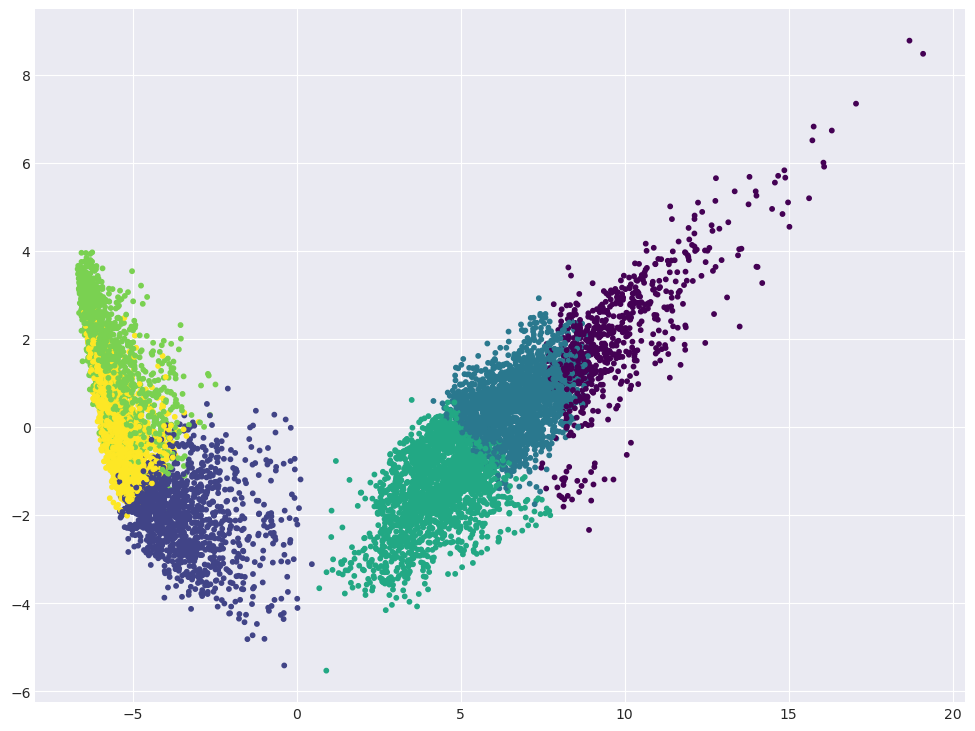

In [18]:
### STUDENT CODE HERE (3 pts)

kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_reduced)
labels_kmeans = kmeans.labels_
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_kmeans, s=10, cmap='viridis');

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Describe the clustering result. What can you see from the resulting plot?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> The two scatter plots only resemble each other very roughly. I think the left super cluster worked pretty good while the right cluste looks a lot different. Of course the k means clustering method is not really able to handle overlapping data like this.
</div>

### 3.3.3 Evaluation of Clustering results using labels
The labels of the data can be used to evaluate our clustering results. However, it is not possible to calculate the same metrics as used in classification tasks. In classification, the output of a classification algorithm is exactly one of the learned classes. In comparison to that, a clustering algorithm only performs an assignment to one cluster, but we do not know  which class a cluster has found. 

#### 3.3.3.1 Cross-Tabulation

<div class="alert alert-block alert-success">
<b>Task:</b> Look at the correspondence between the cluster marks and the original class labels. Therefore, calculate a cross-tabulation of the cluster labels and the real labels of the data points.
    
<b>Hint:</b> Use crosstab from the pandas library
</div>

In [19]:
### STUDENT CODE HERE (2 pts)

# labels of k means start with 0
print(Counter(labels_kmeans))
print(Counter(y))

pd.crosstab(labels_kmeans, y)

### STUDENT CODE until HERE

Counter({5: 2493, 3: 2082, 2: 1917, 4: 1809, 1: 1310, 0: 688})
Counter({6: 1944, 5: 1906, 4: 1777, 1: 1722, 2: 1544, 3: 1406})


label    1     2    3     4     5     6
row_0                                  
0      150    82  456     0     0     0
1        0     0    0   471   667   172
2      865   290  762     0     0     0
3      707  1172  188     3     0    12
4        0     0    0    49     0  1760
5        0     0    0  1254  1239     0

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b>  What kinds of activities is the <code>KMeans</code> algorithm confused with?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> Most confusion happens with the sedentary activities (label: 1,2,3), there are many similarly high numbers in the correspondence. The algorithm seems to perform bether for dynamic activities, since the correspondence values are less ambiguous.
</div>

#### 3.3.3.2 Developing a simple separation metric
We are observing that each class, representing a specific activity, is grouped into distinct clusters. To assess how effectively a particular class is distinguished, we will employ a metric. This metric involves identifying the highest value within each class and then dividing it by the total number of instances belonging to that class. This will give a percentage value that shows, how well the class can be clustered.


Example: if for class "walking downstairs" (with 1406 instances belonging to it), the distribution of clusters is:
 - cluster 1 - 900
 - cluster 3 - 500
 - cluster 6 - 6,
 
then such a share will be 900/1406 $ \approx $ 0.64.


<div class="alert alert-block alert-success">
<b>Task:</b> Calculate this value for all classes.
</div>

In [20]:
### STUDENT CODE HERE (3 pts)

crosstab = pd.crosstab(labels_kmeans, y)

distinguishment_ratios = []
for test_label in y.value_counts().keys():
    distinguishment_ratios.append(((labels[test_label - 1], test_label), crosstab.iloc[:, test_label - 1].max() / crosstab.iloc[:, test_label - 1].sum()))

for elem in distinguishment_ratios:
    print(elem)

### STUDENT CODE until HERE 

(('LAYING', 6), 0.9053497942386831)
(('STANDING', 5), 0.6500524658971668)
(('SITTING', 4), 0.7056837366347777)
(('WALKING', 1), 0.5023228803716608)
(('WALKING_UPSTAIRS', 2), 0.7590673575129534)
(('WALKING_DOWNSTAIRS', 3), 0.5419630156472262)


<div class="alert alert-block alert-success">
<b>Question (2 pt):</b>  Answer the following questions in the answer block below and indicate which question your answer is referring to: <br>
    
1. Which activities are separated from the rest better than others based on the simple metric described above? <br>
2. How would you rate the results in general? Do you have an explanation for the results?
</div>

<div class="alert alert-block alert-success">
<b>Your Answer:</b> 
    
1. Best distinguished activity is laying. Others are not well distinguished, since 50% is not really distinguished. <br>
2. Laying is the only activity where the subject changes its pitch (as in pitch, yaw, roll), which may help to characterize it best.
</div>

------------------------
## 3.4 Classification with Decision Trees and K-Nearest-Neighbor

You can notice that the task of clustering the given dataset is not very well solved when we try to detect several clusters (> 2). Now, let's solve the classification problem, given that the data is labeled.

For classification, use the nearest neighbor classifier – class `sklearn.neighbors.KNeighborsClassifier` and the Decision Tree Classifier – class `sklearn.tree.DecisionTreeClassifier`. We studied these algorithms in course three.

The overall idea for this last part is to make the influence of the PCA algorithm visible. Therefore, first, you will train and evaluate both classifiers on the complete dataset.
Second, you are going to reduce the dimensionality of the data using the PCA algorithm, before training and evaluating both classifiers again.


### 3.4.1 Choosing the best hyperparameters for the algorithms using Cross-Validation

Choose the `n_neighbors` hyperparameter for` KNeighborsClassifier` and the pruning parameter `max_depth` using `GridSearchCV`. 



<div class="alert alert-block alert-success">
<b>Task:</b> First step: Fit the  <code>StandardScaler</code> on the training set (with all original features), but perform only mean centering. Apply scaling to the test set.

</div>

In [25]:
X_train_scaled: np.ndarray
X_test_scaled: np.ndarray

### STUDENT CODE HERE (2 pts)

mean_center_scaler = StandardScaler(with_mean=True, with_std=False)
X_train_scaled = mean_center_scaler.fit_transform(X_train)
X_test_scaled = mean_center_scaler.transform(X_test)

### STUDENT CODE until HERE

# Sanity Check
assert (np.abs(np.mean(X_train_scaled)) < 0.000000001) ^ (np.abs(np.mean(X_test_scaled)) < 0.000000001), f'Expected either train or test set to be fitted for scaling.'

<div class="alert alert-block alert-success">
<b>Task:</b> Second Step: 
Specify a list of parameter values for the Decision Tree and KNeighborsClassifier you want to be evaluated.

</div>

For example:
- Tree: max_depth: None, 5, 10, 15
- KNN: n_neighbors: 3, 5, 7, 9, 11

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

### STUDENT CODE HERE (2 pts)

param_tree = {"max_depth": [None, 5, 10, 15]}
nearest_n_arr = [3, 5, 7, 9, 11]

### STUDENT CODE until HERE


# Use the Grid Search CV for Tree with cv=3 and fixate the 
# random state of the Decision Tree classifier with RANDOM_STATE

### STUDENT CODE HERE (2 pts)

grid_search_tree = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_tree, cv=3)
grid_search_tree.fit(X_train_scaled, y_train)

### STUDENT CODE until HERE


# Do the same Grid Search CV for KNN, again with cv=3 and RANDOM_STATE

### STUDENT CODE HERE (1 pt)

# there is no random state for nearest neighbors

weight_options = ['uniform', 'distance']

k_params = {"n_neighbors": nearest_n_arr, "weights": weight_options}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), k_params, cv=3)
grid_search_knn.fit(X_train_scaled, y_train)

### STUDENT CODE until HERE


# Get the best params, classification score and the model itself for both, the Tree and the KNN

### STUDENT CODE HERE (2 pts)

best_knn = grid_search_knn.best_estimator_
best_knn_score = grid_search_knn.best_score_
best_tree = grid_search_tree.best_estimator_
best_tree_score = grid_search_tree.best_score_

print(f"Best number of neighbors: {grid_search_knn.best_params_}")
print(f"Best tree depth: {grid_search_tree.best_params_}")
best_classifyer = "knn" if best_knn_score > best_tree_score else "tree"
print(f"Best classifyer: {best_classifyer}")

### STUDENT CODE until HERE


# compare your result with the checkpoint
# lama_compare_checkpoint(round(best_knn_score,4), 't4/checkpoint3_2.pkl')
# first score is similar enough (0.8935 should be 0.8928)
lama_compare_checkpoint(round(best_tree_score,4), 't4/checkpoint3_3.pkl')

Best number of neighbors: {'n_neighbors': 9, 'weights': 'distance'}
Best tree depth: {'max_depth': 10}
Best classifyer: knn
Your data looks alright, you can continue with the workbook


True

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Which value of the hyperparameter <code>n_neighbors</code> was chosen the best on the basis of cross-validation? What depth of the tree was selected? Which classifier performed better?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> Neighbor number: 9; tree depth: 10; KNN performed better
</div>

### 3.4.2 Scoring the Test Set

<div class="alert alert-block alert-success">
<b>Task:</b> Now use the best parameter set for the two algorithms and train them on the whole training dataset. Predict the labels of the test set with these models and calculate the accuracy of the two models.

</div>

In [37]:
### STUDENT CODE HERE (2 pts)

# already trained on whole train dataset, since it wasn't specified before
y_pred_knn = best_knn.predict(X_test)
knn_accuracy = metrics.accuracy_score(y_test, y_pred=y_pred_knn)

y_pred_tree = best_tree.predict(X_test)
tree_accuracy = metrics.accuracy_score(y_test, y_pred=y_pred_tree)

print(f"KNN accuracy: {knn_accuracy}")
print(f"Tree accuracy: {tree_accuracy}")

### STUDENT CODE until HERE

KNN accuracy: 0.3898880217170003
Tree accuracy: 0.27926705123854767


<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Which algorithm performs better on the test set? Which algorithm has better generalization abilities? Interpret the results.
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> The KNN algortihm performs much better than the tree algorithm, so it has better generalization abilities in our case, since we don't have clear boundaries for the data, which would benefit the decision trees.
</div>

### 3.4.3 Adding PCA to the Classification 

<div class="alert alert-block alert-success">
<b>Task:</b> Finally, do the same thing as in the Question before, but add PCA with the typical value of explained variance we discussed before.
<ul>
<li> Use <code>X_train_scaled</code> and <code>X_test_scaled</code>
<li> Train the PCA as before, on the scaled training set
<li> Apply PCA transformation to the test set
<li> Fill in the correct number of features (post-PCA)

</li>
</ul>
Please define the variable correct_number_of_features as well (See secound code box)
</div>

In [39]:
X_train_pca: np.ndarray
X_test_pca: np.ndarray

### STUDENT CODE HERE (2 pts)

correct_number_of_features = pc_count

PCA_90 = decomposition.PCA(n_components=correct_number_of_features, random_state=RANDOM_STATE)
X_train_pca = PCA_90.fit_transform(X_train_scaled)
X_test_pca = PCA_90.transform(X_test_scaled)

### STUDENT CODE until HERE

# The shape of the train and test data should have the amount of features we observed above.

# correct_number_of_features = ??? ## define me!!!
assert(X_train_pca.shape == (7352, correct_number_of_features)), f'For the dataset a different shape was expected'
assert(X_test_pca.shape == (2947, correct_number_of_features)), f'For the dataset a different shape was expected'

<div class="alert alert-block alert-success">
<b>Task:</b> Choose the hyperparameters via cross-validation on the training set with PCA-transformation. (Just copy your code from above but use the PCA-transformed dataset)

</div>

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Do you notice a speed difference for the training process? What do you observe if you compare the optimal hyperparameters?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> GridSearch is muuuuuuch quicker with reduced dataset (4 sec, compared to 49 sec). Both optimal parameters changed, and interestingly both increased significantly.
</div>

In [46]:
%time
### STUDENT CODE HERE (2 pts)

param_tree = {"max_depth": [None, 5, 10, 15, 20, 25, 30]}
nearest_n_arr = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27]

grid_search_tree = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_tree, cv=3)
grid_search_tree.fit(X_train_pca, y_train)

weight_options = ['uniform', 'distance']
k_params = {"n_neighbors": nearest_n_arr, "weights": weight_options}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), k_params, cv=3)
grid_search_knn.fit(X_train_pca, y_train)

best_knn_pca = grid_search_knn.best_estimator_
best_knn_score_pca = grid_search_knn.best_score_
best_tree_pca = grid_search_tree.best_estimator_
best_tree_score_pca = grid_search_tree.best_score_

print(f"Best number of neighbors: {grid_search_knn.best_params_}")
print(f"Best tree depth: {grid_search_tree.best_params_}")
best_classifyer = "knn" if best_knn_score > best_tree_score else "tree"
print(f"Best classifyer: {best_classifyer}")

### STUDENT CODE until HERE

CPU times: total: 0 ns
Wall time: 0 ns
Best number of neighbors: {'n_neighbors': 23, 'weights': 'uniform'}
Best tree depth: {'max_depth': 15}
Best classifyer: knn


<div class="alert alert-block alert-success">
<b>Task:</b> Now finally evaluate the results on the test set. Use the accuracy metric. 

</div>

In [49]:
### STUDENT CODE HERE (2 pts)

y_pred_knn_pca = best_knn_pca.predict(X_test_pca)
knn_accuracy_pca = metrics.accuracy_score(y_test, y_pred=y_pred_knn_pca)

y_pred_tree_pca = best_tree_pca.predict(X_test_pca)
tree_accuracy_pca = metrics.accuracy_score(y_test, y_pred=y_pred_tree_pca)

print(f"KNN PCA accuracy: {knn_accuracy_pca}")
print(f"Tree PCA accuracy: {tree_accuracy_pca}")

### STUDENT CODE until HERE

KNN PCA accuracy: 0.8873430607397353
Tree PCA accuracy: 0.8109942314217848


<div class="alert alert-block alert-success">
<b>Question (2 pts):</b> What do you observe? What is the difference between the best quality (accuracy) for the test set in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent. Do you have an explanation for the different behavior of the two algorithms?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> </br>
    KNN accuracy: 0.39 </br>
    Tree accuracy: 0.28 </br>
    KNN PCA accuracy: 0.89 </br>
    Tree PCA accuracy: 0.81 </br>
    KNN difference: 0.5 </br>
    Tree difference: 0.53 </br>
    Observation: Accuracy of reduced data models is much higher.</br>
    Explanation: Curse of dimensionality
</div>

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b>  Select all the correct statements:
<ul>
<li> Principal component analysis in this case allowed to reduce the model training time, while the quality (accuracy) stays nearly the same
<li> PCA can be used to visualize data, but there are better methods for this task, for example, [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). However, PCA has lower computational complexity 
<li> PCA builds linear combinations of initial features, and in some applications they might be poorly interpreted by humans 
</li>
</ul>
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> 
<ul>
<li> Partially correct, training time is reduced while quality stays same or increases.
<li> Partially correct, T-distributed Stochastic Neighbor Embedding also expects to reduce data to reasonable number of PCs.
<li> True
</ul>
</div>

# Feedback and Recap

<div class="alert alert-block alert-success">
<b>Question (3pt):</b>  Please conclude in a few sentences what you learned in this exercise
</div>

<div class="alert alert-block alert-success">
<b>Your Answer:</b> </br>
    We learned how to use PCA to reduce high dimensional data to reasonable amount of features and the impact it has on the performance of the model. </br>
    Further we learned how to cluster unlabeled data and evaluate the goodness of clusters. </br>
    Next we compared the unsupervised classification methods with the actually labelled data.</br>
    Finally we evaluated how PCA impacts the unsupervised classification methods.
</div>

## And give us feedback if you like


1) Do you think this task was designed well? 

2) Where can we improve this task?

<strong>Thanks for participating in LAMA! :)</strong>

1. This task 4.3 was nice summarizing and using everything we have learned so far. But the volume is high, it took us many hours to complete.
2. Implementing the algorithms ourselves took too much time while adding little additional understanding. The pseudocode for the k-means clustering was incomplete, because it did not include how to treat centroids which don't get datapoints assigned because they are too far away. This led to a lot of time lost finding the problem.